In [83]:
from alphavantage import AlphaVantage
import pandas as pd
import plotly.graph_objects as go
import numpy as np

In [84]:
av = AlphaVantage('BCHSP7W9RIPI6UMS')
df = pd.DataFrame(av.get_daily_adjusted('IBM', 'full'))
df['MA'] = df['Close'].rolling(window=5).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Close'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA'], mode='lines', name='MA'))
fig.show()

In [85]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))



closes=df.reset_index()['Close']
closes=scaler.fit_transform(np.array(closes).reshape(-1,1))

In [86]:
##splitting dataset into train and test split
training_size=int(len(closes)*0.65)
test_size=len(closes)-training_size
train_data,test_data=closes[0:training_size,:],closes[training_size:len(closes),:1]

In [87]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [88]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [89]:
print(X_train.shape), print(y_train.shape)

(3506, 100)
(3506,)


(None, None)

In [90]:
print(X_test.shape), print(ytest.shape)

(1842, 100)
(1842,)


(None, None)

In [91]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [92]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [93]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
55/55 [==============================] - 21s 286ms/step - loss: 0.0128 - val_loss: 0.0021
Epoch 2/100
55/55 [==============================] - 14s 254ms/step - loss: 8.0882e-04 - val_loss: 0.0018
Epoch 3/100
55/55 [==============================] - 13s 243ms/step - loss: 7.8822e-04 - val_loss: 0.0018
Epoch 4/100
55/55 [==============================] - 13s 245ms/step - loss: 7.7601e-04 - val_loss: 0.0017
Epoch 5/100
55/55 [==============================] - 13s 243ms/step - loss: 7.4660e-04 - val_loss: 0.0016
Epoch 6/100
55/55 [==============================] - 13s 243ms/step - loss: 7.1085e-04 - val_loss: 0.0019
Epoch 7/100
55/55 [==============================] - 13s 243ms/step - loss: 6.9895e-04 - val_loss: 0.0015
Epoch 8/100
55/55 [==============================] - 14s 251ms/step - loss: 6.8198e-04 - val_loss: 0.0015
Epoch 9/100
55/55 [==============================] - 13s 243ms/step - loss: 6.2950e-04 - val_loss: 0.0013
Epoch 10/100
55/55 [==============================

55/55 [==============================] - 15s 273ms/step - loss: 1.1670e-04 - val_loss: 2.3256e-04
Epoch 76/100
55/55 [==============================] - 15s 270ms/step - loss: 1.2208e-04 - val_loss: 2.4362e-04
Epoch 77/100
55/55 [==============================] - 14s 251ms/step - loss: 1.4697e-04 - val_loss: 2.3253e-04
Epoch 78/100
55/55 [==============================] - 13s 243ms/step - loss: 1.2231e-04 - val_loss: 2.3613e-04
Epoch 79/100
55/55 [==============================] - 14s 247ms/step - loss: 1.2571e-04 - val_loss: 2.4320e-04
Epoch 80/100
55/55 [==============================] - 13s 241ms/step - loss: 1.3387e-04 - val_loss: 7.0389e-04
Epoch 81/100
55/55 [==============================] - 16s 294ms/step - loss: 2.1930e-04 - val_loss: 2.4505e-04
Epoch 82/100
55/55 [==============================] - 15s 276ms/step - loss: 1.2759e-04 - val_loss: 2.3132e-04
Epoch 83/100
55/55 [==============================] - 13s 242ms/step - loss: 1.2031e-04 - val_loss: 2.3240e-04
Epoch 84/100
5

In [95]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)



##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [96]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

81.8129081443895

In [97]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

117.78095052434627

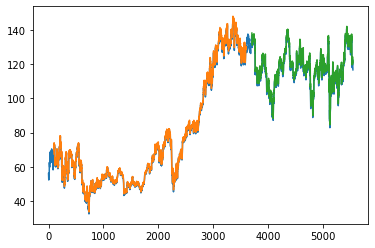

In [98]:
import matplotlib.pyplot as plt
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(closes)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(closes)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closes)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(closes))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [99]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape


(1, 100)

In [100]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [101]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [102]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

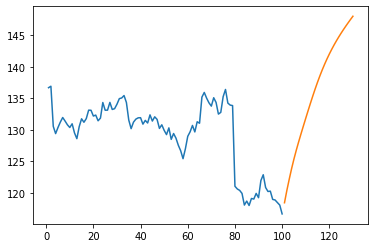

In [103]:
plt.plot(day_new,scaler.inverse_transform(closes[len(closes)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [104]:
print(scaler.inverse_transform(lst_output))
print(lst_output)

[[118.42958193]
 [120.37212224]
 [122.14206844]
 [123.81824547]
 [125.3497266 ]
 [126.76264547]
 [128.08684269]
 [129.35585905]
 [130.59500059]
 [131.8175564 ]
 [133.02544154]
 [134.2124663 ]
 [135.36840564]
 [136.48255581]
 [137.5462033 ]
 [138.55370557]
 [139.5028466 ]
 [140.39410518]
 [141.23015553]
 [142.01485512]
 [142.75277955]
 [143.4486207 ]
 [144.10710465]
 [144.73271809]
 [145.32975622]
 [145.90215172]
 [146.45355688]
 [146.98742563]
 [147.50678102]
 [148.01439303]]
[[0.7498760223388672], [0.7668048739433289], [0.7822296023368835], [0.7968371510505676], [0.8101837038993835], [0.8224970102310181], [0.8340371251106262], [0.8450963497161865], [0.8558952212333679], [0.866549551486969], [0.8770760297775269], [0.8874207139015198], [0.8974944949150085], [0.9072040915489197], [0.9164735674858093], [0.9252537488937378], [0.9335253238677979], [0.9412924647331238], [0.9485784769058228], [0.9554169774055481], [0.9618478417396545], [0.967911958694458], [0.9736505150794983], [0.97910261154

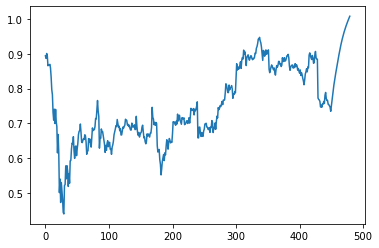

In [105]:
df3=closes.tolist()
df3.extend(lst_output)
plt.plot(df3[5100:])